# Проект "Исследование рынка компьютерных игр"

### Оглавление

* [Вступление](#id_1)
 * [Библиотеки](#id_1a)
 * [Описание данных](#id_1b)
 * [Цель проекта](#id_1b1)
 * [Загрузка файлов](#id_1c)
 * [Необходимые функции](#id_1d)
* [Предобработка](#id_2)
 * [Названия колонок](#id_2a)
 * [Работа с пропусками](#id_2b)
   * [Колонки critic score и user score](#id_2b1)
   * [Колонки name, genre](#id_2b2)
   * [Колонка year_of_release](#id_2b3)
   * [Колонка rating](#id_2b4)
 * [Поиск дубликатов](#id_2c)
 * [Приведение типов](#id_2d)
 * [Создание очищенной таблицы](#id_2e)
 * [Создание дополнительных колонок](#id_2f)
* [Анализ данных](#id_3)
 * [Количество выпущенных игр по годам](#id_3a)
 * [Количество выпущенных игр по платформам](#id_3b)
 * [Суммарные продажи по платформам](#id_3c)
 * [Распределение игр по жанрам](#id_3c1)
 * [Количество выпущенных игр по годам для платформ с наибольшими суммарными продажами](#id_3d)
 * [Определение жизненного цикла платформы](#id_3e)
 * [Определение актуального периода для платформы](#id_3f)
 * [Диаграмма boxplot по глобальным продажам игр за 2013-2016 года](#id_3g)
 * [Влияние отзывов пользователей и критиков на продажи за 2013-2016 года](#id_3h)
 * [Распределение игр по жанрам за 2013-2016 года](#id_3j)
 * [Прогноз продаж на 2017 год](#id_3k)
 * [Портрет игрока в каждом регионе за 2013-2016 года](#id_3l)
 * [Распределение жанров по регионам, 2013-2016 года](#id_3m)
 * [Влияние рейтингов на продажи, 2013-2016 года](#id_3n)
 * [Проверка гипотез](#id_3o)
   * [Средние пользовательские рейтинги платформ Xbox One и PC одинаковые ](#id_3o1)
   * [Средние пользовательские рейтинги жанров Action и Sports разные. ](#id_3o2)
 * [Выводы](#id_4)

## Вступление <a class="anchor" id="id_1"></a>

### Библиотеки <a class="anchor" id="id_1a"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import requests
import re
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Описание данных <a class="anchor" id="id_1b"></a>

**Name** — название игры  
**Platform** — платформа  
**Year_of_Release** — год выпуска  
**Genre** — жанр игры  
**NA_sales** — продажи в Северной Америке (миллионы проданных копий)  
**EU_sales** — продажи в Европе (миллионы проданных копий)  
**JP_sales** — продажи в Японии (миллионы проданных копий)  
**Other_sales** — продажи в других странах (миллионы проданных копий)  
**Critic_Score** — оценка критиков (максимум 100)  
**User_Score** — оценка пользователей (максимум 10)  
**Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  
Данные за 2016 год могут быть неполными.

### Цель проекта <a class="anchor" id="id_1b1"></a>

Как сотруднику игрового интернет-магазина мне нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Загрузка файлов <a class="anchor" id="id_1c"></a>

In [2]:
data = pd.read_csv('/datasets/games.csv', sep = ',')

### Необходимые функции <a class="anchor" id="id_1d"></a>

In [3]:
# Функция для вывода пропущенных значений в датафрейме, просто вызовите ее, указав нужный датафрейм в параметрах
def missing_values_tab(df):
    #Подсчет количества пропущенных значений
    mis_val = df.isnull().sum()
    #Подсчет доли пропущенных значений в колонке в процентах
    mis_val_percent = round(100 * df.isnull().sum() / len(df),2)
    #Объединяем две созданных колонки в один датафрейм с параметром axis=1, чтобы добавить их справа-слева
    mv_table = pd.concat([mis_val, mis_val_percent], axis=1)  
    #Переименование колонок
    mv_table = mv_table.rename(columns = {0 : 'Пропущенные значения', 1 : '% от всех значений'})
    #Создаем колонку с типом данных 
    mv_table['Тип данных'] = df.dtypes
    mv_table = mv_table[mv_table.iloc[:,1]!=0].sort_values(by='Пропущенные значения',ascending=False)
    print ("Ваш датафрейм содержит " + str(df.shape[1]) + " колонок и " + str(df.shape[0]) + " строк.\n")
    print("Он имеет  " + str(mv_table.shape[0]) +" колонок с пропущенными значениями.")    
    return display(mv_table) 

In [4]:
#Функция для вывода  списков более 1000 элементов в юпитере без многоточий
def print_long_lists(lst):
    count=0
    n=1
    while count<len(lst):
        print(lst[count:n*1000],end=' ')        
        count+=1000
        n+=1
        if count==len(lst):
            print(lst[-1])
    else:
        print('\nКонец списка, количество элементов: ',len(lst))  

In [5]:
#Функция для приведения колонок к нижнему регистру
def column_name_formatter (name):
    name_lowercase = name.lower()    
    return name_lowercase

In [6]:
#Функция для определения границ разброса значений у boxplots
def get_swipe_range(dataset):
    
    median = pd.DataFrame.median(dataset)
    mean = pd.DataFrame.mean(dataset)
    min_value =  pd.DataFrame.min(dataset)
    max_value = pd.DataFrame.max(dataset)
    quartile_1 = pd.DataFrame(dataset).quantile(0.25,numeric_only=False)
    quartile_3 = pd.DataFrame(dataset).quantile(0.75,numeric_only=False)
    # Interquartile range
    iqr = round(quartile_3-quartile_1,2)
    #Вычисление границ размаха
    left_swipe_value = round(quartile_1-1.5*iqr,2)
    right_swipe_value = round(quartile_3+1.5*iqr,2)    
    print('Границы разброса значений для колонки:',dataset.name)         
    print('Левое значение: %s' % left_swipe_value.to_string())
    print('Правое значение: %s' % right_swipe_value.to_string())

## Предобработка <a class="anchor" id="id_2"></a>

In [7]:
display(data.head())


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


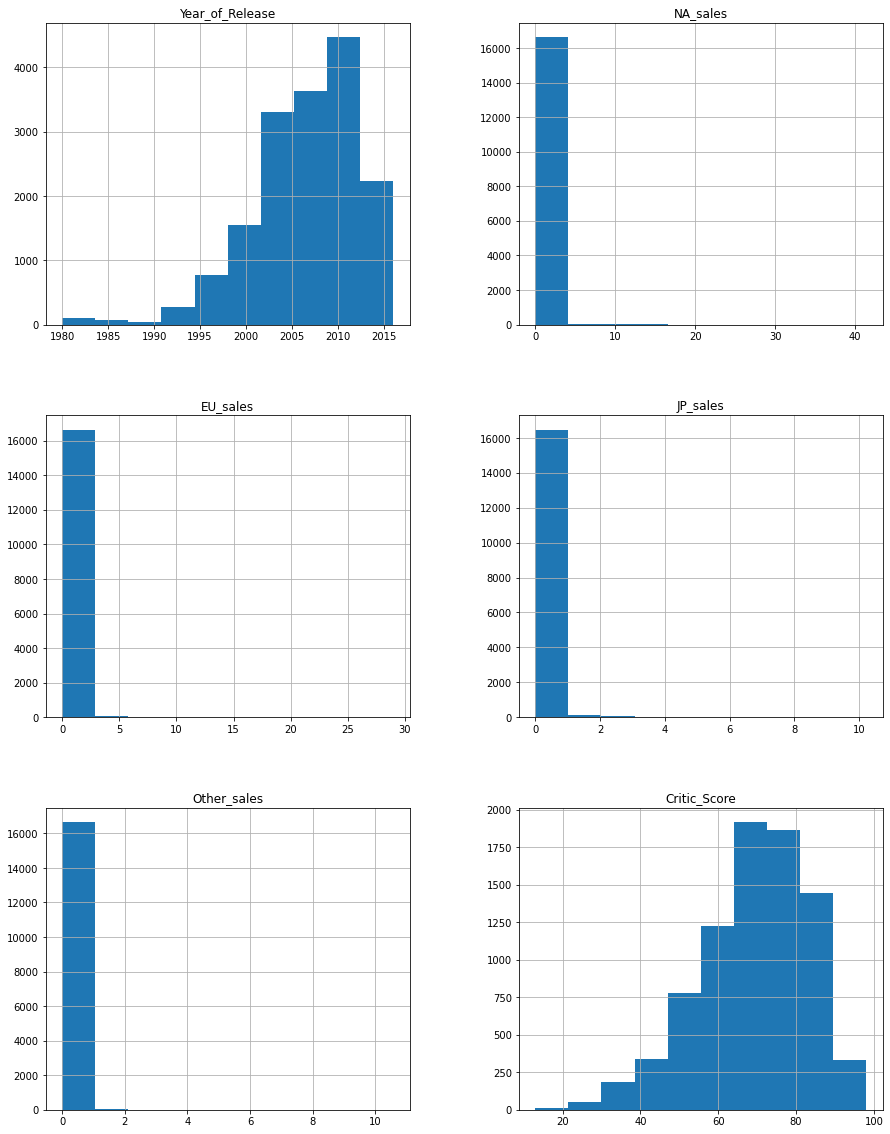

In [9]:
#построение диаграмм
data.hist(figsize=(15,20))
plt.show()

Осмотр диаграммы позволяет сделать следующие выводы:
- спектр дат выхода игр варьируется от 1980 до 2016, больше всего было выпущено в 2010-2013 гг;
- главным рынком по числу проданных копий является американский (в районе 5 млн), затем европейский;
- оценка критиков в основном в диапазлне 70-80 баллов;
- поля user_score и rating надо привести к числовому типу.

### Названия колонок <a class="anchor" id="id_2a"></a>

Названия колонок приведу к нижнему регистру:

In [10]:
def column_name_formatter (name):
    name_lowercase = name.lower()    
    return name_lowercase

In [11]:
data.columns = map(column_name_formatter, data.columns)
print(data.columns.values)

['name' 'platform' 'year_of_release' 'genre' 'na_sales' 'eu_sales'
 'jp_sales' 'other_sales' 'critic_score' 'user_score' 'rating']


### Работа с  пропусками <a class="anchor" id="id_2b"></a>

In [12]:
missing_values_tab(data)

Ваш датафрейм содержит 11 колонок и 16715 строк.

Он имеет  6 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных
critic_score,8578,51.32,float64
rating,6766,40.48,object
user_score,6701,40.09,object
year_of_release,269,1.61,float64
name,2,0.01,object
genre,2,0.01,object


**Колонки critic score и user score** <a class="anchor" id="id_2b1"></a>

In [13]:
print(data['user_score'].unique())

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


Из-за значения "tbd" колонка имеет формат object, а  не float. Это значение подразумевает, что рейтинг будет определен в будущем, то есть можно принять его за пропуск.

In [14]:
print(data[(data['critic_score'].isna()) & (data['user_score'].isna())].shape[0])
print(data[(data['critic_score'].isna()) & (data['user_score'].isna()) & (data['rating'].isna())].shape[0])

6663
6621


In [15]:
data.groupby("name").filter(lambda x: len(x) > 9).sort_values(['name'], ascending = False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Как видно, подавляющая часть пропусков в колонках рейтингов совпадает по строкам. По видимому это связано с ошибками при парсинге данных с игровых ресурсов. Остальные несовпадающие пропуски скорее всего приходятся на отдельные игры, которые или были выпущены очень давно, или прошли незаметно для игроков и критиков.   
Пропуски в них можно заполнить, если в таблице есть их версии для других платформ без пропусков в этих полях. Но оценки могут разниться в зависимости от платформы, поэтому средним значением заполнить не получиться. Я принял решение заполнить пропуски в обеих колонках нулем, если он там не встречается.
Также информацию об оценках можно найти, если собрать информацию в интернете, но следует учитывать, что эта таблица содержит срез данных до 2016 года, а свежие данные будут содержать оценки вплоть до текущего ммомента. Прежде всего это касается оценок пользователей. 

In [16]:
data.query('critic_score==0')
#так как нуль не встречается среди значений, можно им заполнить пропуски
data['critic_score'] = data['critic_score'].fillna(0)

In [17]:
data.query('user_score=="0"')
#Так он есть, заполню значением -1
data['user_score'] = data['user_score'].replace('tbd',-1)
data['user_score'] = data['user_score'].fillna(-1)


**Колонки name, genre** <a class="anchor" id="id_2b2"></a>

In [18]:
display(data.query('name.isna()'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,0.0,-1,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,0.0,-1,NaN


Пропуски, наверно, как-то связаны с тем, что игры очень старые. Так как они содержат интересующие нас данные( объемы продаж по регионам, год, платформа) , то лучше их оставить и заменить пропуски значением "неизвестно".

In [19]:
data['name'] = data['name'].fillna('unknown')
data['genre'] = data['genre'].fillna('unknown')

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
Доля пропусков здесь менее 5% и для экономии времени их можно удалить.
</div>

**Колонка year_of_release** <a class="anchor" id="id_2b3"></a>

In [20]:
print(data['year_of_release'].unique())

[2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]


In [21]:
display(data.query('year_of_release.isna()'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,0.0,-1,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,0.0,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,-1,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,0.0,-1,NaN


In [22]:
display(data.query('year_of_release.isna()')['platform'].unique())
display(data['platform'].unique())

array(['PS2', 'Wii', '2600', 'X360', 'GBA', 'PC', 'PS3', 'PS', 'PSP',
       'XB', 'GB', 'DS', 'GC', '3DS', 'N64', 'PSV'], dtype=object)

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Причина пропусков в поле year_of_release скорее всего связана как с проблемами с соединением при сборе данных (у тех игр, где пропуски и в других полях), но в случае строк с пропуском только в этом поле я затрудняюсь указать причину.  
В случае игр типа "madden nfl 2004" дату выхода можно вычислить из названия игры(обычно они выходят годом раньше, чем цифра в заголовке). Другие пропуски можно заполнить сбором информации из сети(вариант с заполнением пропусков с помощью парсера вынесен в приложение, так как процесс долгий и я приложил файлы с собранной информацией.)

Можно попробовать по парам имя-платформа найти, если заполненные данные по году:

In [23]:
data.groupby(['name','platform'])['year_of_release'].value_counts().sort_values(ascending = False)


name                              platform  year_of_release
unknown                           GEN       1993.0             2
Madden NFL 13                     PS3       2012.0             2
 Beyblade Burst                   3DS       2016.0             1
Rascal                            PS        1998.0             1
Ratatouille                       GC        2007.0             1
                                                              ..
Halo Wars                         X360      2009.0             1
Halo: Combat Evolved              PC        2003.0             1
                                  XB        2001.0             1
Halo: Combat Evolved Anniversary  X360      2011.0             1
¡Shin Chan Flipa en colores!      DS        2007.0             1
Name: year_of_release, Length: 16444, dtype: int64

In [24]:
display(data.query('name=="Madden NFL 13"'))
display(data.query('name=="unknown"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,0.0,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,unknown,GEN,1993.0,unknown,1.78,0.53,0.00,0.08,0.0,-1,NaN
14244,unknown,GEN,1993.0,unknown,0.00,0.00,0.03,0.00,0.0,-1,NaN


In [25]:
#до исправления
display(data.query('name=="Madden NFL 2004"'))
display(data.query('name=="Tomb Raider (2013)"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
646,Tomb Raider (2013),PS3,2013.0,Action,0.60,1.26,0.08,0.48,0.0,-1,NaN
910,Tomb Raider (2013),X360,2013.0,Action,0.86,0.84,0.01,0.17,0.0,-1,NaN
1384,Tomb Raider (2013),PS4,2014.0,Action,0.47,0.65,0.06,0.22,0.0,-1,NaN
3309,Tomb Raider (2013),XOne,2014.0,Action,0.35,0.21,0.00,0.05,0.0,-1,NaN
5336,Tomb Raider (2013),PC,NaN,Action,0.06,0.25,0.00,0.04,86.0,8.5,M


Заполнение пропусков по дате выхода у игр с годом в названии:

In [26]:
found_titles = []
for name in data.query('year_of_release.isna()')['name']:
    if name =='Tomb Raider (2013)':
        data.loc[data['name']==name,'year_of_release'] = data.fillna(2013)
    else:
        if (re.search('[0-9]{4}',str(name))): # ищем имена с 4 цифрами подряд
            found_titles.append(name)
            for ele in re.split(' ', str(name)): #найденные разбиваем по пробелу и проходимся по его элементам итератором
                if re.match('\d{4}',str(ele)): #находим элемент года
                ## in case of 'pes 2009: pro evolution soccer'
                    year = str(ele).replace(':','').strip() #очищаем его от пропусков и двоеточия                    
                    data.loc[data['name']==name,'year_of_release'] = data.fillna(int(year)-1)
      

In [27]:
#после исправления
display(data.query('name=="Madden NFL 2004"'))
display(data.query('name=="Tomb Raider (2013)"'))
print(data['year_of_release'].isna().sum())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
646,Tomb Raider (2013),PS3,2013.0,Action,0.60,1.26,0.08,0.48,0.0,-1,NaN
910,Tomb Raider (2013),X360,2013.0,Action,0.86,0.84,0.01,0.17,0.0,-1,NaN
1384,Tomb Raider (2013),PS4,2014.0,Action,0.47,0.65,0.06,0.22,0.0,-1,NaN
3309,Tomb Raider (2013),XOne,2014.0,Action,0.35,0.21,0.00,0.05,0.0,-1,NaN
5336,Tomb Raider (2013),PC,2013.0,Action,0.06,0.25,0.00,0.04,86.0,8.5,M


252


Остальные пропуски можно заполнить нулем, так как они содержат полезную информацию.

In [28]:
data['year_of_release'] = data['year_of_release'].fillna(0)

**Колонка rating** <a class="anchor" id="id_2b4"></a>

In [29]:
print(data['rating'].isna().sum())
print(data['rating'].unique())

6766
['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


 - **"E"** -  «Для всех»: Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально "K-A" ("Kids to Adults");
 - **"E10+"** - «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови;
 - **"T"** - «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики;
 - **"M"** - «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику;
 - **"АО"** - аналогично Е;
 - **"ЕС"** - «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры.

			

Изучение справочной информации об этих рейтингах на ресурсах википедии https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board и https://www.esrb.org/ratings-guide/ позволило установить, что рейтинги "E" и "K-A" Обозначают одно и то же, только последний уже не используется. Рейтинг RP - "rating pending", что можно принять за пропуск. Обычно рейтинг один для версий игры для различных платформ и редко пересматривается (например, после выхода дополнений к играм), поэтому можно посмотреть, нет ли игр, где одновременно есть рейтинг и есть пропуски.

In [30]:
data['rating'] = data['rating'].replace({'K-A':"E"})

In [31]:
data.groupby('name')['name',"platform", 'rating'].filter(lambda x: len(x) > 8).sort_values(['name','rating'])

/tmp/ipykernel_48/999534973.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('name')['name',"platform", 'rating'].filter(lambda x: len(x) > 8).sort_values(['name','rating'])


,name,platform,rating
126,FIFA 14,PS3,E
271,FIFA 14,X360,E
469,FIFA 14,PS4,E
1753,FIFA 14,XOne,E
4699,FIFA 14,PSV,E
4809,FIFA 14,PC,E
4985,FIFA 14,Wii,E
7875,FIFA 14,PSP,E
6871,FIFA 14,3DS,NaN
730,LEGO Marvel Super Heroes,X360,E10+


Такие игры есть и можно заполнить пропуски самым распространенным значением.

In [32]:
titles = ['FIFA 14','LEGO Marvel Super Heroes','Need for Speed: Most Wanted','Ratatouille','pro evolution soccer 2011']
for title in titles:
    group_mode = data.query('name==@title')['rating'].mode()    
    data.loc[(data['name']==title) & (data['rating'].isnull()),'rating'] =data.fillna(group_mode[0])    
    

Оставшиеся пропуски заполню значением "RP"

In [33]:
data['rating'] = data['rating'].fillna("RP")

#### Итоги по пропускам

<span style="color:green">Флаги для выборок</span>: 
- data['year_of_release'] != 0 
- data[user_score] != (-1)
- data['critic_score'] = 0

In [34]:
missing_values_tab(data)

Ваш датафрейм содержит 11 колонок и 16715 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


### Поиск дубликатов в названии игр <a class="anchor" id="id_2c"></a>

<span style = "color:red">Необходимо привести к ниженему регистру</span>

In [35]:
text_cols = ['name', 'platform', 'genre','rating']
for col in text_cols:
    data[col] = data[col].str.lower()

In [36]:
data = data.drop_duplicates()
print(data.shape[0])

16715


In [37]:
print(data['name'].duplicated().sum())

5155


In [38]:
display(data[data['name'].duplicated()].head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
23,grand theft auto v,x360,2013.0,action,9.66,5.14,0.06,1.41,97.0,8.1,m
35,call of duty: black ops ii,x360,2012.0,shooter,8.25,4.24,0.07,1.12,83.0,4.8,m
37,call of duty: modern warfare 3,ps3,2011.0,shooter,5.54,5.73,0.49,1.57,88.0,3.2,m
41,call of duty: black ops,ps3,2010.0,shooter,5.99,4.37,0.48,1.79,88.0,6.4,m
42,grand theft auto v,ps4,2014.0,action,3.96,6.31,0.38,1.97,97.0,8.3,m


Дубликаты в названиях связаны с тем, что игры перевыпускаются для разных платформ, поэтому главными их идентификаторами является пара имя- платформа (и может быть, год).

Проверка на неявные дубликаты:

In [39]:
data[data[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012.0,sports,2.11,0.22,0.00,0.23,83.0,5.5,e
659,unknown,gen,1993.0,unknown,1.78,0.53,0.00,0.08,0.0,-1,rp
14244,unknown,gen,1993.0,unknown,0.00,0.00,0.03,0.00,0.0,-1,rp
16230,madden nfl 13,ps3,2012.0,sports,0.00,0.01,0.00,0.00,83.0,5.5,e


In [40]:
display(data[data['name']=='madden nfl 13'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,madden nfl 13,x360,2012.0,sports,2.53,0.15,0.0,0.17,81.0,5.8,e
604,madden nfl 13,ps3,2012.0,sports,2.11,0.22,0.0,0.23,83.0,5.5,e
3986,madden nfl 13,wii,2012.0,sports,0.47,0.00,0.0,0.03,0.0,7.3,e
5887,madden nfl 13,psv,2012.0,sports,0.28,0.00,0.0,0.02,63.0,7.3,e
7066,madden nfl 13,wiiu,2012.0,sports,0.21,0.00,0.0,0.02,75.0,6.7,e
16230,madden nfl 13,ps3,2012.0,sports,0.00,0.01,0.0,0.00,83.0,5.5,e


Строчка номер 16230 является дубликатов строки 604, поэтому ее можно удалить. Строки 659 и 14244 с большой вероятностью дублируют друг друга, тем более, что ранее были заполнены подобранным значением колонки названия и жанра.
Удалю строку 14244, она содержит меньше всего информации:

In [41]:
data = data.loc[data.index.drop([16230, 14244])]

### Приведение типов <a class="anchor" id="id_2d"></a>

Колонка year_of_release,critic_score -> int
        user_score -> float
         

In [42]:
data['year_of_release'] = data['year_of_release'].astype('int')
data['critic_score'] = data['critic_score'].astype('int')
data['user_score'] = data['user_score'].astype('float')

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


### Очищенная таблица данных <a class="anchor" id="id_2e"></a>

Так как меня интересуют данные, которые позволят выявить закономерности, которые определяют успешность игры, придется отсечь данные, где год = 0, так как привязка ко времени имеет значение.

In [44]:
cleared_data = data.query('year_of_release != 0')
print(data.shape[0]/cleared_data.shape[0])

1.0153089119737562


In [45]:
# Архивная копия на всякий случай
cleared_data_copy = cleared_data.copy(deep = True)

### Создание дополнительных колонок <a class="anchor" id="id_2f"></a>

Создание колонки суммарных продаж

In [46]:
cleared_data['total_sales'] = cleared_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
# Изменение порядка колонок
cols = cleared_data.columns.to_list()
cols = cols[:-4] + cols[-1:] + cols[-4:-1]
cleared_data = cleared_data[cols]
display(cleared_data.head())

/tmp/ipykernel_48/277039337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleared_data['total_sales'] = cleared_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,82.54,76,8.0,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,40.24,0,-1.0,rp
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,35.52,82,8.3,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,32.77,80,8.0,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,31.38,0,-1.0,rp


**Вывод**: Исходная таблица данных содержала от 40 до 50% пропусков в колонках отзывов критиков и игроков. Так как эти параметры важны для целей исследования, было принято решение не удалять их, а заполнить подобранными значениями, что может сказаться на точности исследования. После этого, колонка critic_score была переведена в тип int, а колонка user_score  - в тип float, колонка с датой релиза игры была переведена в тип int.
Новая очищенная таблица на 254 строчки меньше оригинальной.

## Анализ данных <a class="anchor" id="id_3"></a>

### Количество выпущенных игр по годам. <a class="anchor" id="id_3a"></a>

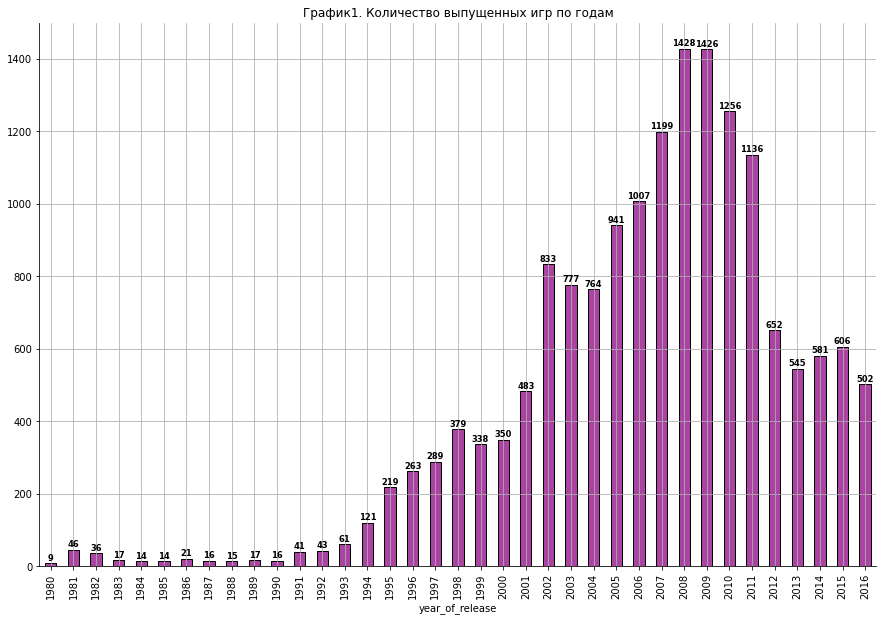

In [47]:
plot_data_1 = cleared_data.groupby('year_of_release')['name'].count()
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure()
ax = fig.add_subplot()
ax = plot_data_1.plot(kind = 'bar', figsize = (15,10), ax = ax, grid = True,
                 ec = 'black',  color = color, title = 'График1. Количество выпущенных игр по годам')
 #Убирание рамок вложенных графиков           
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
rects=ax.patches
for rect in rects:    
    height = rect.get_height()    
    ax.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom", weight='bold',size='small')

Количество выпущенных игр  начинает расти с 1991 года (когда Нинтендо выпустила приставку SNES) и достигает максимума в 2008 году(1441 игра). Поэтому для анализа можно брать отрезок времени с 1991 года.

### Количество выпущенных игр по платформам <a class="anchor" id="id_3b"></a>

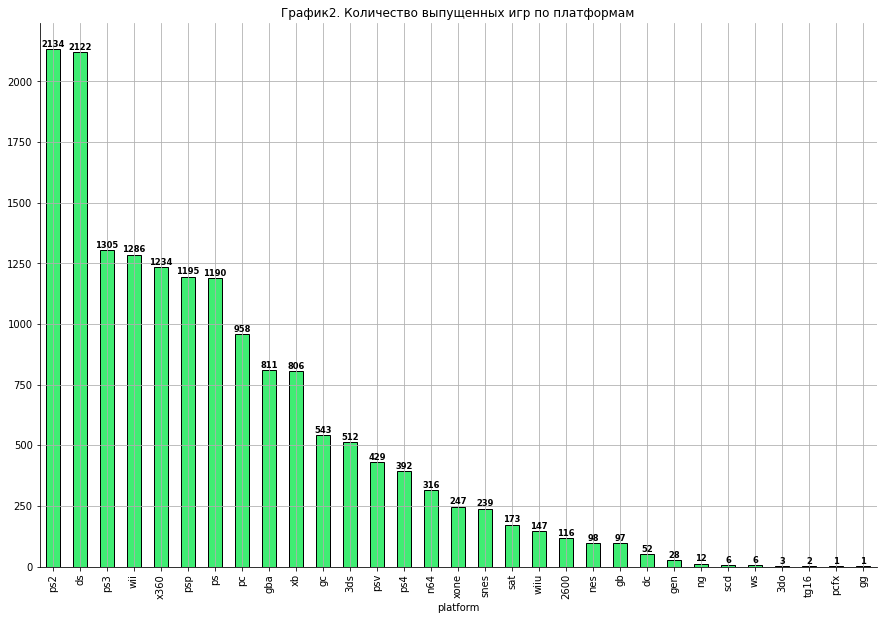

In [48]:
plot_data_2 = cleared_data.groupby('platform')['name'].count().sort_values(ascending = False)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure()
ax = fig.add_subplot()
ax = plot_data_2.plot(kind = 'bar', figsize = (15,10), ax = ax, grid = True,
                 ec = 'black',  color = color, title = 'График2. Количество выпущенных игр по платформам')
 #Убирание рамок вложенных графиков           
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
rects=ax.patches
for rect in rects:    
    height = rect.get_height()    
    ax.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom", weight='bold',size='small')

Больше всего игр было выпущено для Playstation 2(2134) и Nintendo DS(2122).

### Суммарные продажи по платформам <a class="anchor" id="id_3c"></a>

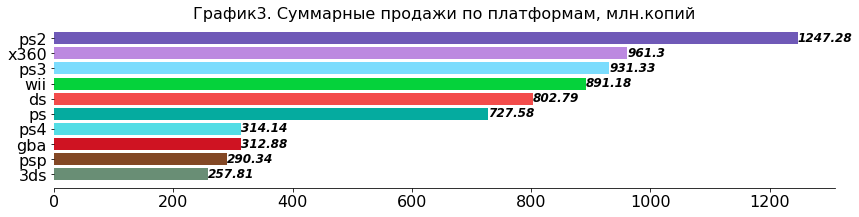

In [49]:
plot_data_3 = cleared_data.groupby('platform')['total_sales'].sum().sort_values().tail(10)
color_list = []
for x in range(len(plot_data_3.index)):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])][0]
    color_list.append(color)
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot()
ax.barh( plot_data_3.index.values, plot_data_3, color=color_list)
#Оформление
ax.set_title('График3. Суммарные продажи по платформам, млн.копий',size=16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',labelsize=16)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='large', style='oblique',
            weight='bold', color='k',ha='left') 
plt.show()

Несмотря на то, что игр для x360, wii  и ps3 было выпущено почти на 1000 меньше, чем для Nintendo DS, они продались лучше. То есть для них было выпущено больше успешных игр.

### Распределение игр по жанрам. <a class="anchor" id="id_3c1"></a>

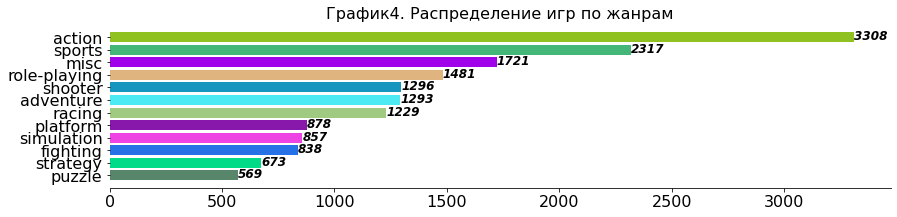

In [50]:
plot_data_4 = (cleared_data
                .query('genre != "unknown"')
                .groupby('genre')['name'].count().sort_values()
               )
color_list = []
for x in range(len(plot_data_4.index)):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])][0]
    color_list.append(color)
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot()
ax.barh( plot_data_4.index.values, plot_data_4, color=color_list)
#Оформление
ax.set_title('График4. Распределение игр по жанрам',size=16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',labelsize=16)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='large', style='oblique',
            weight='bold', color='k',ha='left') 
plt.show()

Больше всего выпущено игр в жанре action, спортивных и misc( видимо сюда входят игры, которые не вошли в другие категории, например казуальные или ммо). Это связано с тем, что основная аудитория игр с момента их появления до где средины 2010 годов была мужская, юноши от 10 до 35 лет. Только потом игровые компании начали обращать внимание на женскую аудиторию. С другой стороны, хотя стратегии и пазлы занимают последние места по продажам, они имеют более устойчивую аудиторию и для них легче прогнозировать продажи (на графике видно, что у них меньше разрыв между медианой и третим квартилем.).

### Количество выпущенных игр по годам для платформ с наибольшими суммарными продажами. <a class="anchor" id="id_3d"></a>

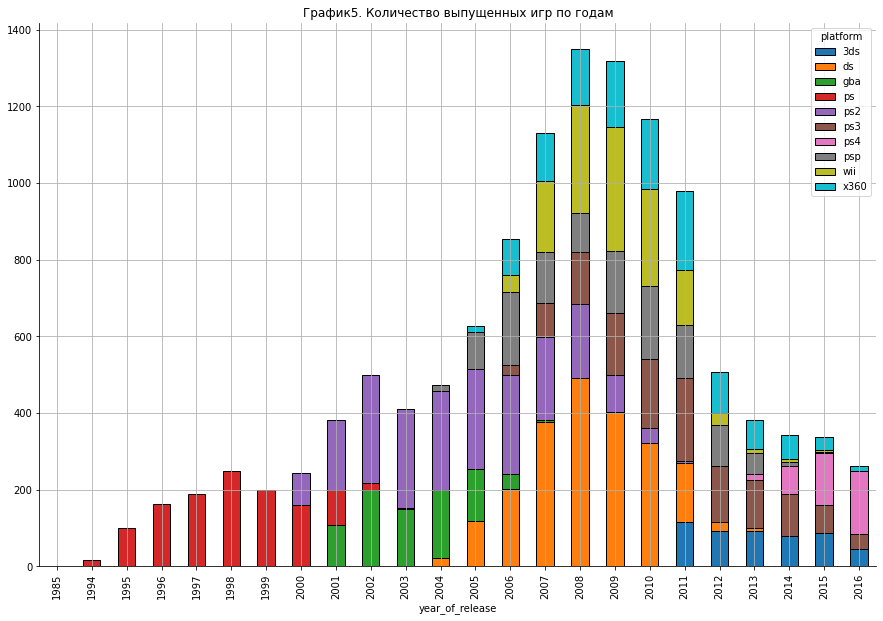

In [51]:
platform_list = plot_data_3.index.values
plot_data_5 = cleared_data[cleared_data['platform'].isin(platform_list)].pivot_table(
    index = 'year_of_release',
    columns = ['platform'], values = 'name', aggfunc = 'count')
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure()
ax = fig.add_subplot()
ax = plot_data_5.plot(kind = 'bar', figsize = (15,10), ax = ax, grid = True, stacked = True, 
                 ec = 'black',   title = 'График5. Количество выпущенных игр по годам')
#Убирание рамок вложенных графиков           
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Из диаграммы заметно, что период до 2001 года был эрой "Playstation", затем в с 2000 по 2010 год наступила очередь "Playstation 2", а с 2004 по 2011 года - период консоли Nintendo DS (ds). Также на этот период накладывается период жизни консоли Nintendo wii, выпущенной в 2006 году и до 2011 года.

### Определение жизненного цикла платформы. <a class="anchor" id="id_3e"></a>

In [52]:
end_year = cleared_data.groupby('platform')['year_of_release'].max()
first_year = cleared_data.groupby('platform')['year_of_release'].min()
cleared_data = cleared_data.assign(lifetime  = lambda row:row['platform'].map(end_year - first_year))
display(cleared_data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating,lifetime
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,82.54,76,8.0,e,10
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,40.24,0,-1.0,rp,11
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,35.52,82,8.3,e,10
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,32.77,80,8.0,e,10
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,31.38,0,-1.0,rp,13


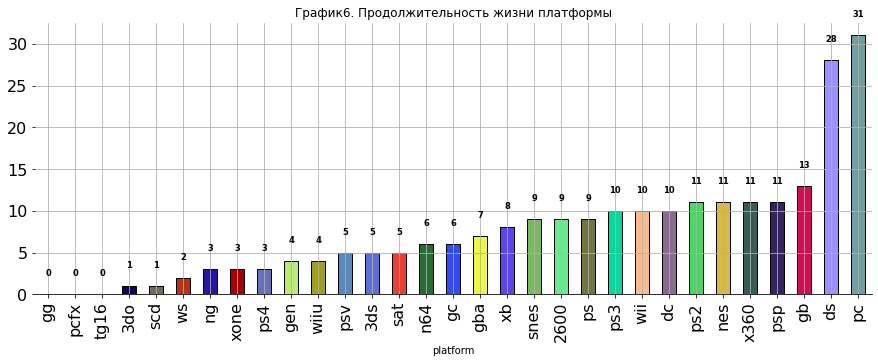

In [53]:
plot_data_6 = cleared_data.groupby('platform')['lifetime'].mean().sort_values(ascending = True)
color_list = []
for x in range(len(plot_data_6.index)):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])][0]
    color_list.append(color)
fig = plt.figure()
ax = fig.add_subplot()
plot_data_6.plot(kind = 'bar', figsize = (15,5), ax = ax, grid = True,
                 ec = 'black',  color = color_list , title = 'График6. Продолжительность жизни платформы')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',labelsize=16)
#Надписи
rects=ax.patches
for rect in rects:    
    height = rect.get_height()    
    ax.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom", weight='bold',size='small')
plt.show()

Самыми живучими являются компьютеры и Nintendo DS, выпущенная  1985 году.

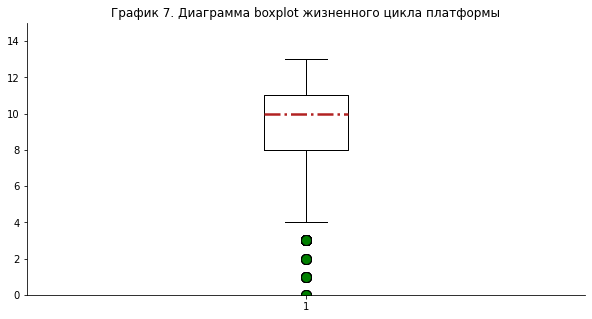

In [54]:
fig = plt.figure(figsize=(10 ,5))
ax = fig.add_subplot()
flierprops = dict(marker='o', markerfacecolor='green', markersize=10, linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
ax.boxplot(cleared_data['lifetime'], flierprops=flierprops, medianprops=medianprops)
ax.set_ylim(0,15); 
ax.set_title('График 7. Диаграмма boxplot жизненного цикла платформы')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [55]:
get_swipe_range(cleared_data['lifetime'])

Границы разброса значений для колонки: lifetime
Левое значение: lifetime    3.5
Правое значение: lifetime    15.5


Средняя продолжительность жизни консоли без учета аномалий составляет:

In [56]:
print(cleared_data.query('3.5<= lifetime <= 15.5')['lifetime'].mean().round())

9.0


### Определение актуального периода для прогноза на 2017 год. <a class="anchor" id="id_3f"></a>

График 4 за период с 2004 года, когда началась эпоха Nintendo DS:

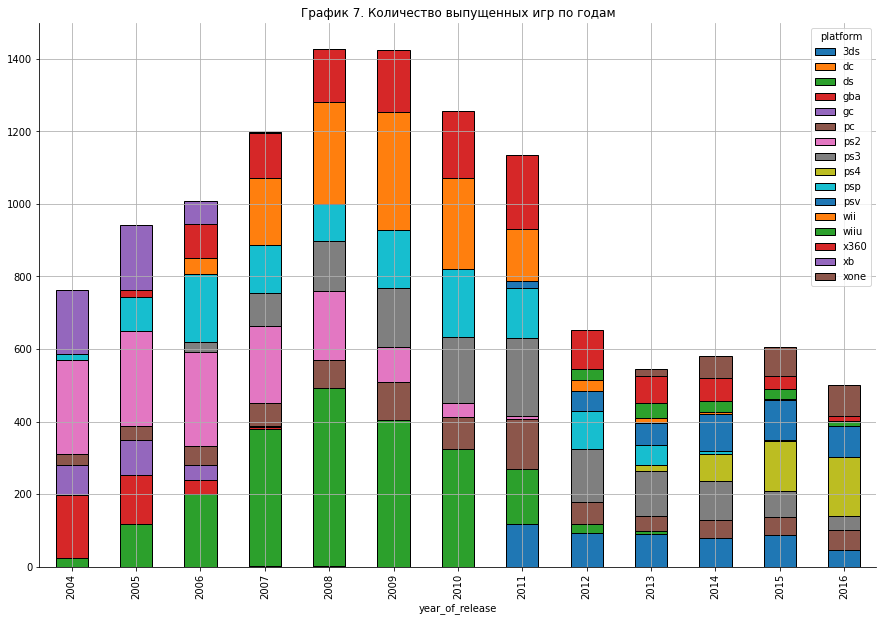

In [57]:
plot_data_7 = cleared_data.query('year_of_release >=2004').pivot_table(index = 'year_of_release',
                                                                       columns = ['platform'], 
                                                                        values = 'name', 
                                                                        aggfunc = 'count')
fig = plt.figure()
ax = fig.add_subplot()
ax = plot_data_7.plot(kind = 'bar', figsize = (15,10), ax = ax, grid = True, stacked = True, 
                 ec = 'black',   title = 'График 7. Количество выпущенных игр по годам')
#Убирание рамок вложенных графиков           
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Исходя из результатов на графике 4 и средней продолжительности жизни платформы, актуальным периодом для расчета прогноза будет период с 2013 года, когда заканчивается предыдущий цикл консолей (DS, Wii,PSP, PS2) и появляются новые (PS4, X One)

### Диаграмма boxplot по глобальным продажам игр за 2013 -2016 года <a class="anchor" id="id_3g"></a>

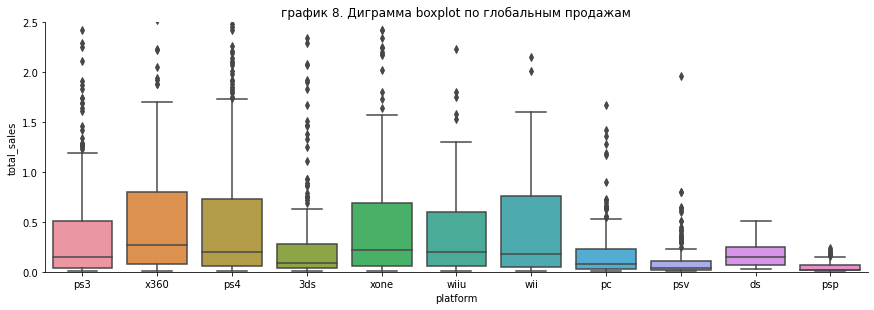

In [58]:
sns.catplot(x='platform',
            y='total_sales',
            kind='box', 
            data=cleared_data.query('year_of_release >=2013'),
            height=4, aspect=3).set(title = 'график 8. Диграмма boxplot по глобальным продажам')
plt.ylim(0, 2.5);
plt.show()

На графике 8 можно выделить противостояние консолей нового поколения (ps4, xone, wii u, nintendo 3ds) с консолями уходящего поколения (ps3, x360, ds). Заметно, что у косолей нового поколения  больше аномалий на правой стороне распределения, оттягивающих хвост в эту сторону

### Влияние отзывов пользователей и оценок критиков на продажи за 2013-2016 года <a class="anchor" id="id_3h"></a>

In [59]:
#Необходимо отфильтровать заполненные значения 0 и -1 для критиков и пользователей
plot_data_8 = (cleared_data.query('year_of_release >=2013')
               .query('critic_score != 0')
               [['platform','total_sales','critic_score','user_score']]
              )
plot_data_8u = (cleared_data.query('year_of_release >=2013')
               .query('user_score != (-1)')[['platform','total_sales','critic_score','user_score']]
               )

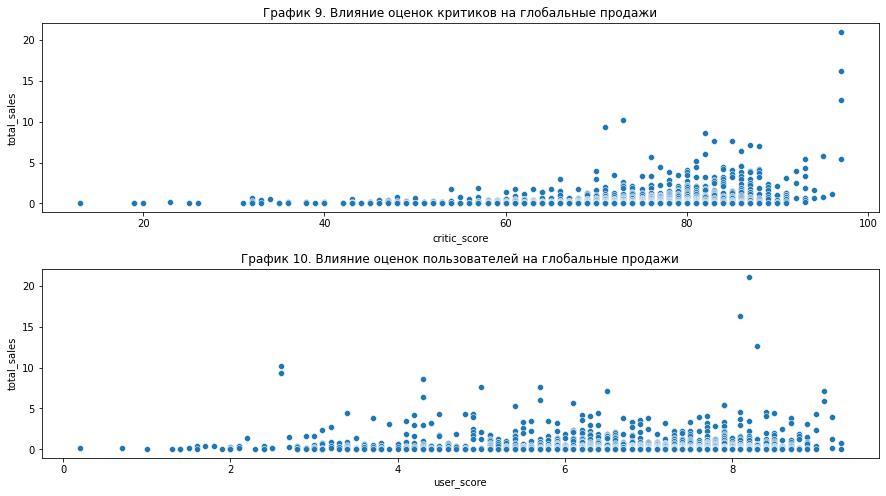

In [60]:
fig, axes = plt.subplots(2,1, figsize=(15,8),sharex=False)
sns.scatterplot(x = 'critic_score', 
                y = 'total_sales',
                data = plot_data_8, ax = axes[0]
                ).set(title = "График 9. Влияние оценок критиков на глобальные продажи")

sns.scatterplot(x = 'user_score', 
                y = 'total_sales',
                data = plot_data_8u, ax = axes[1]
                ).set(title = "График 10. Влияние оценок пользователей на глобальные продажи")
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

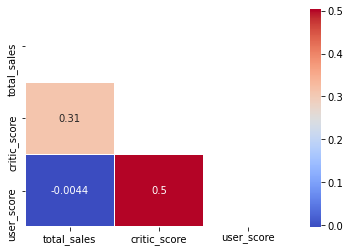

In [61]:
corr =  plot_data_8.query('user_score !=(-1)')[['total_sales', 'critic_score', 'user_score']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot = True, fmt='.2g', cmap= 'coolwarm', linewidths=.5, mask=mask)

Если рассматривать все платформы, то оценки критиков и пользователей имеют слабую положительную связь с глобальным продажами. Это может говорить о том, что или покупатели мало обращают внимания на обзоры игр, принимая решение об их покупке, или покупатели также не обращают внимание на отзывы игроков, потому что там могут быть слишком много аномалий(неадекватно низких оценок потому, что игроку чем-то не угодили, или неадектватно высоких из-за того, что игрок является ярым фанатом этой игры)

Рассмотрю платформу Playstation 3:

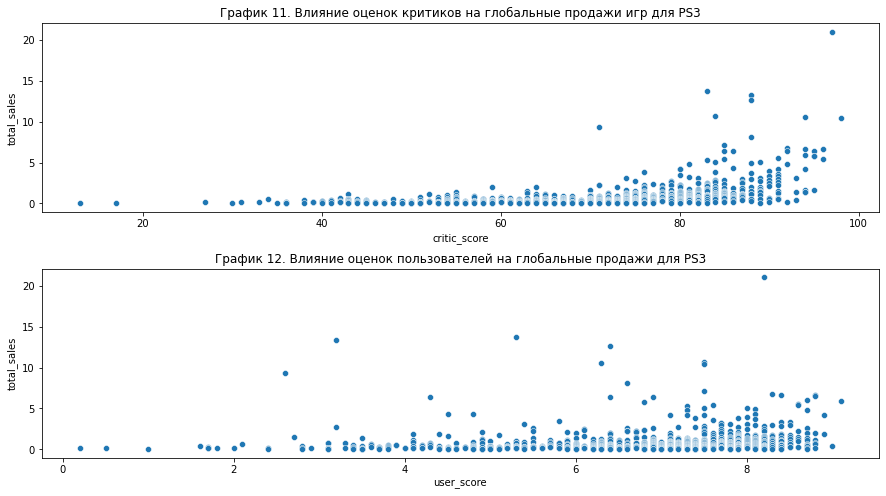

In [62]:
#Для оценок кртиков надо отфильтровать заполненные значения с нулем
plot_data_9 = (cleared_data.query('critic_score != 0')
               .query('platform=="ps3"')[['platform','total_sales','critic_score','user_score']]
                                 )
fig, axes = plt.subplots(2,1, figsize=(15,8),sharex=False)
sns.scatterplot(x = 'critic_score', 
                y = 'total_sales',
                data = plot_data_9, ax = axes[0]
                ).set(title = "График 11. Влияние оценок критиков на глобальные продажи игр для PS3")
#Для оценок пользователей надо отфильтровать заполненные значения -1
plot_data_9a = cleared_data.query('platform=="ps3" & user_score != -1')[['platform','total_sales','critic_score','user_score']]
sns.scatterplot(x = 'user_score', 
                y = 'total_sales',
                data = plot_data_9a, ax = axes[1]
                ).set(title = "График 12. Влияние оценок пользователей на глобальные продажи для PS3")
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

<AxesSubplot:>

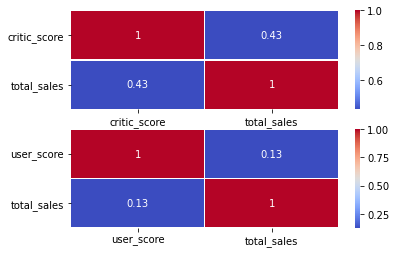

In [63]:
fig, axes = plt.subplots(2,1,sharex=False)
corr =  plot_data_9[['critic_score','total_sales']].corr()
corr_1 = plot_data_9a[['user_score','total_sales']].corr()
sns.heatmap(corr, annot = True, fmt='.2g', cmap= 'coolwarm', linewidths=.5, ax = axes[0])
sns.heatmap(corr_1, annot = True, fmt='.2g', cmap= 'coolwarm', linewidths=.5,  ax = axes[1])

Значение	 корреляции:
 от 0 до 0,3	очень слабая,
 от 0,3 до 0,5	слабая,
 от 0, 5 до 0,7	средняя,
 от 0,7 до 0, 9	высокая,
 от 0,9 до 1	очень высокая

По графику корреляции видно, что оценка критиков имеет слабую положительную связь с продажами, а оценка пользователей - очень слабую положительную.

### Распределение игр по жанрам за 2013-2016 года <a class="anchor" id="id_3j"></a>

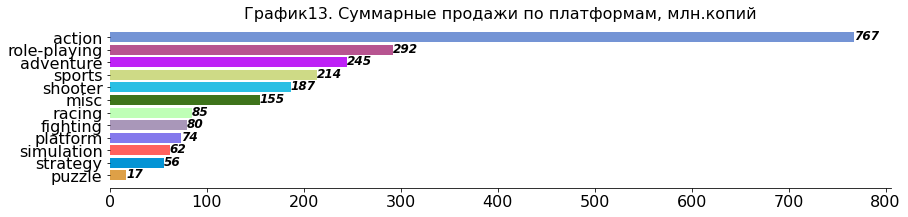

In [64]:
plot_data_10 = (cleared_data.query('year_of_release >=2013')
                .query('genre != "unknown"')
                .groupby('genre')['name'].count().sort_values()
               )
color_list = []
for x in range(len(plot_data_10.index)):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])][0]
    color_list.append(color)
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot()
ax.barh( plot_data_10.index.values, plot_data_10, color=color_list)
#Оформление
ax.set_title('График13. Суммарные продажи по платформам, млн.копий',size=16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',labelsize=16)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='large', style='oblique',
            weight='bold', color='k',ha='left') 
plt.show()

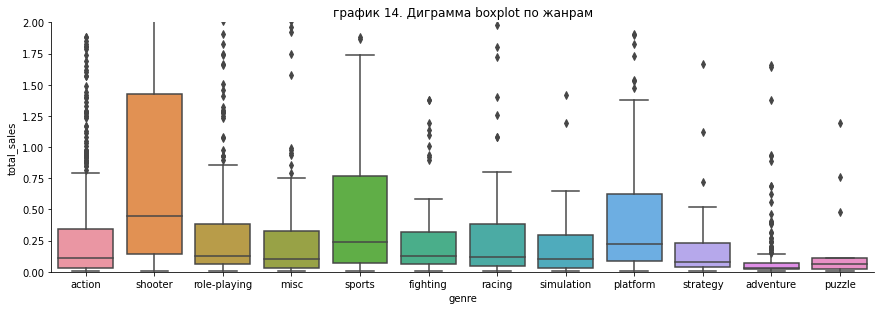

In [65]:
sns.catplot(x='genre',
            y='total_sales',
            kind='box', 
            data=cleared_data.query('genre != "unknown"').query('year_of_release >=2013'),
            height=4, aspect=3).set(title = 'график 14. Диграмма boxplot по жанрам')
plt.ylim(0, 2);
plt.show()

В 2013-2016 годах видно преобладание игр жанра Action, затем различных рпг и адвенчур. Но по диграмме боксплотов видно, что шутеры очень сильно выделяются по размаху и медианному значению, также спортивные игры и платформеры. 
Игры жанра action, rpg, misc, fighting,racing,simulation можно отнести к одной группе по медианным продажам.

### Построение прогноза продаж на 2017 год c помощью линейной регрессии <a class="anchor" id="id_3k"></a>

Целевая переменная total_sales.

#### Предобработка данных

Так как работа над пропусками была проведена, осталось перевести категориальные колонки в цифровые аналоги, стандартизировать данные и посмотреть на выбросы.  
Для преобразования категориальных значений буду использовать метод get_dummies(), как наиболее подходящий для линейной регресии.

In [66]:
forecast_2017 = cleared_data.query('user_score != (-1)')

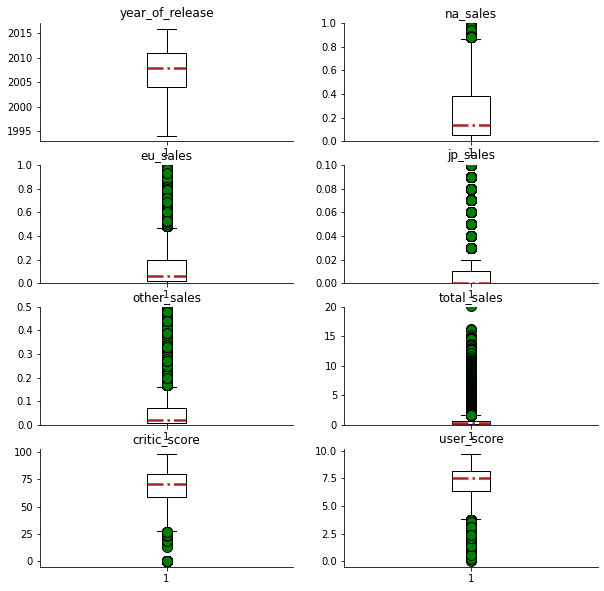

In [67]:
cols = ['year_of_release', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales', 'critic_score', 'user_score']
fig = plt.figure(figsize=(10 ,10))
count = 0
for column in cols:    
    ax = fig.add_subplot(4,2,count+1)
    flierprops = dict(marker='o', markerfacecolor='green', markersize=10, linestyle='none')
    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    ax.boxplot(forecast_2017.query('year_of_release >= 1993')[column], flierprops=flierprops, medianprops=medianprops)    
    ax.set_title(f'{column}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if column in ['na_sales','eu_sales','other_sales']:
        ax.set_ylim(0,1)    
    if column =='jp_sales':
        ax.set_ylim(0,0.1)
    if column == 'other_sales':        
        ax.set_ylim(0,0.5) 
    if column == 'total_sales':        
        ax.set_ylim(0,20) 
    count+=1
plt.show()

In [68]:
for column in cols:
    print("Column:", column, np.percentile(forecast_2017[column], [95, 99]))

Column: year_of_release [2015. 2016.]
Column: na_sales [1.4645 3.4058]
Column: eu_sales [0.9345 2.4016]
Column: jp_sales [0.28 1.07]
Column: other_sales [0.3    0.9029]
Column: total_sales [2.78   6.9464]
Column: critic_score [89. 94.]
Column: user_score [8.9 9.2]


Аномальные значения:  
year_of_release < 1993    
critic_score <27.5 и critic_score > 94  
user_score<3.7 и critic_score > 9.2  
na_sales <= 3.4  
eu_sales <= 2.4
jp_sales <= 1.07

In [69]:
forecast_2017_cleared = (
    forecast_2017.query('year_of_release >= 1993')
    .query('27.5 <= critic_score <= 94')
    .query(' 3.7 <= user_score <= 9.2')
    
                        ).drop(['name','lifetime'],axis = 1)

In [70]:
display(forecast_2017_cleared)

,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,wii,2006,sports,41.36,28.96,3.77,8.45,82.54,76,8.0,e
2,wii,2008,racing,15.68,12.76,3.79,3.29,35.52,82,8.3,e
3,wii,2009,sports,15.61,10.93,3.28,2.95,32.77,80,8.0,e
6,ds,2006,platform,11.28,9.14,6.50,2.88,29.80,89,8.5,e
7,wii,2006,misc,13.96,9.18,2.93,2.84,28.91,58,6.6,e
...,...,...,...,...,...,...,...,...,...,...,...
16673,gba,2002,fighting,0.01,0.00,0.00,0.00,0.01,81,8.8,m
16692,pc,2014,action,0.00,0.01,0.00,0.00,0.01,80,7.6,m
16696,pc,2011,shooter,0.01,0.00,0.00,0.00,0.01,61,5.8,t
16702,pc,2011,strategy,0.00,0.01,0.00,0.00,0.01,60,7.2,e10+


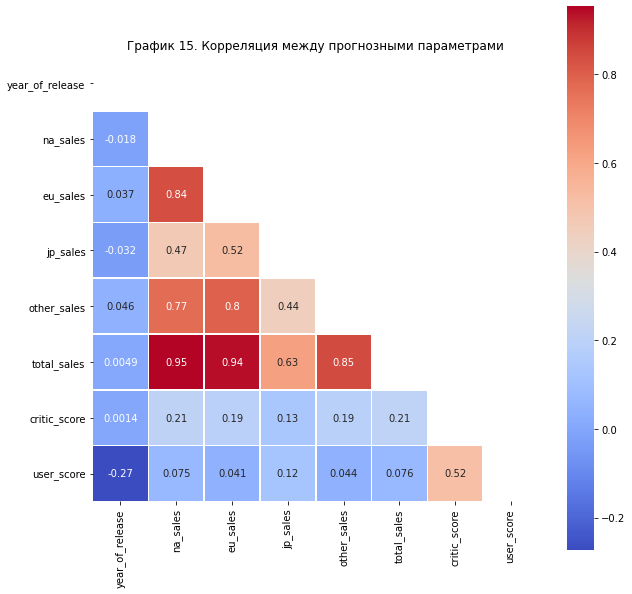

In [71]:
plt.figure(figsize=(10,10))
corr =  forecast_2017_cleared.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot = True, fmt='.2g', 
                 cmap= 'coolwarm',
                 linewidths=.5, 
                 mask=mask, 
                 square = True).set (title = "График 15. Корреляция между прогнозными параметрами")
plt.show()

Удаление пары высококоррелируемых признаков:

In [72]:
forecast_2017_cleared = forecast_2017_cleared.drop(['eu_sales', 'other_sales'], axis = 1)

In [73]:
forecast_2017_cleared = pd.get_dummies(forecast_2017_cleared)

Для разделения данных на выборки использую метод random_split, так как данные по времени не связаны между собой.

In [74]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = forecast_2017_cleared.drop('total_sales', axis = 1)
y = forecast_2017_cleared['total_sales']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Количестов строе в обучающей выборке: ', X_train.shape[0],
      '\nКоличество строк в тестовой выборке: ', X_test.shape[0])
print(X_test.shape[0]/X_train.shape[0])


Количестов строе в обучающей выборке:  5262 
Количество строк в тестовой выборке:  1316
0.250095020904599


In [75]:
# стандартизирую данные методом StandartScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# задам алгоритм Lasso 
model = Lasso() 

# обучение модели
model.fit(X_train_st,y_train)

# Вычисление прогнозов
predictions = model.predict(X_test_st)

# создам датафрейм с признаками и их весами
features = pd.DataFrame({'feature':X.columns,'coeff':model.coef_})
features['coeff_abs'] = features['coeff'].abs()

#  среднее значение целевой переменной на тесте
print('Mean: {:.2f}'.format(y_test.mean()))

# основные метрики
print('MAE: {:.2f}'.format(mean_absolute_error(y_test, predictions)))
print('MSE: {:.2f}'.format(mean_squared_error(y_test, predictions)))
print('R2: {:.2f}'.format(r2_score(y_test, predictions)))


Mean: 0.78
MAE: 0.47
MSE: 1.30
R2: 0.65


In [76]:
print(model.coef_) # вывод значений весов при признаках
print(model.intercept_) # вывод нулевого коэффициента

[ 0.          0.76636591  0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.          0.          0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.        ]
0.7314557202584568


Вывод: Средняя абсолютная ошибка при среднем значении прогнозной переменной 0.78 выглядит плохо, коэффициент детерминации 65 тоже средний.

In [77]:
display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,8.0,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,0,-1.0,rp
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,8.3,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,8.0,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,0,-1.0,rp


In [78]:
na_sales = data.groupby('year_of_release')['na_sales'].sum()
#Так таблица содержит неполные данные за 2016 год, возьму для расчета 2015
total_sales_2017 = 0.73 + 0.76*(0.73+0.76*na_sales.loc[2015,])
print(total_sales_2017)

63.007136


Прогноз на 2017 год - около 63 млн проданных копий.

### Портрет игрока в каждом регионе за 2013-2016 года <a class="anchor" id="id_3l"></a>

Определение доли региона в глобальных продажах для каждой платформы:

In [79]:
regional_sales = cleared_data.query('year_of_release >=2013').groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'total_sales']].sum().assign(
na_share_pct = lambda row: (row['na_sales']/row['total_sales']*100).round(1),
eu_share_pct = lambda row: (row['eu_sales']/row['total_sales']*100).round(1),
jp_share_pct = lambda row: (row['jp_sales']/row['total_sales']*100).round(1)
)
display(regional_sales.sort_values('na_sales', ascending=False).head(10))

,na_sales,eu_sales,jp_sales,total_sales,na_share_pct,eu_share_pct,jp_share_pct
platform,,,,,,,
ps4,108.74,141.09,15.96,314.14,34.6,44.9,5.1
xone,93.12,51.59,0.34,159.32,58.4,32.4,0.2
x360,81.66,42.52,0.51,136.80,59.7,31.1,0.4
ps3,63.50,67.81,23.35,181.43,35.0,37.4,12.9
3ds,38.20,30.96,67.81,143.25,26.7,21.6,47.3
wiiu,29.21,19.85,10.88,64.63,45.2,30.7,16.8
pc,11.17,25.61,0.00,39.78,28.1,64.4,0.0
wii,6.56,5.93,0.05,13.66,48.0,43.4,0.4
psv,5.04,6.10,18.59,32.99,15.3,18.5,56.4


<Figure size 432x288 with 0 Axes>

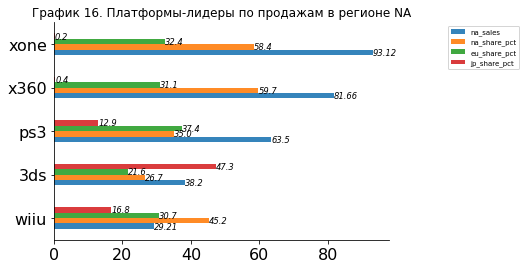

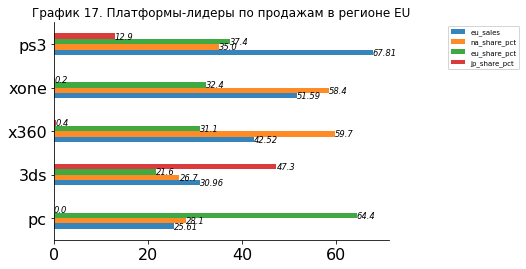

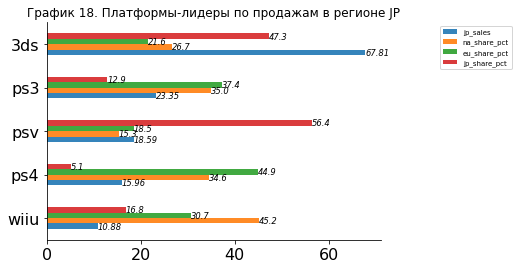

In [80]:
dfs = [regional_sales.query('0 < na_sales < 100')[['na_sales', 'na_share_pct',
                                                   'eu_share_pct',
                                                  'jp_share_pct']].sort_values('na_sales', ascending=True).tail(5),
       regional_sales.query('0 < eu_sales < 100')[['eu_sales', 'na_share_pct',
                                                   'eu_share_pct',
                                                  'jp_share_pct']].sort_values('eu_sales', ascending=True).tail(5),
       regional_sales.query('0 < jp_sales < 100')[['jp_sales', 'na_share_pct',
                                                   'eu_share_pct',
                                                 'jp_share_pct']].sort_values('jp_sales', ascending=True).tail(5)]
titles = ['NA','EU','JP']  #названия вложенных графиков
count = 0
fig = plt.figure()
for df in dfs:
    
    #df = df.iloc[:,1:] #удалить первую по индексу колонку (с продажами), чтобы она не нарушала размерность
    ax = df.plot.barh(stacked=False, alpha=0.9, title = f'График {16+count}. Платформы-лидеры по продажам в регионе {titles[count]}')
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both',labelsize=16)
    ax.legend(prop={'size':7},bbox_to_anchor=(1.4,1))    
    count +=1 
    #Надписи
    rects = ax.patches
    for bar in rects:    
        width = bar.get_width()    
        ax.text(width, bar.get_y(), str(round(width, 2)),fontsize='small', style='oblique',
            weight='normal', color='k',ha='left')
plt.show()

Из графика видно, что в регионе Северной Америки лидером по продажам является платформы от Микрософт,XBox One и XBox 360, имеющие долю продаж почти 60% на родном рынке. Консоль Playstation 3 идет на третьем месте, 35% ее продаж приходится на этот рынок. Затем идут консоли нового поколения 3ds и Wii U. 
На европейском рынке по продажам лидирует Playstation 3, 37% ee продаж приходится на этот рынок. Также следует отметить популярность игр на компьютерах у европейцев, имеющих там 64% своих продаж.
На японском рынке доминируют консоли Нинтендо 3ds, а также другие японские платформы.

### Продажи по жанрам по регионам за 2013-2016 года <a class="anchor" id="id_3m"></a>

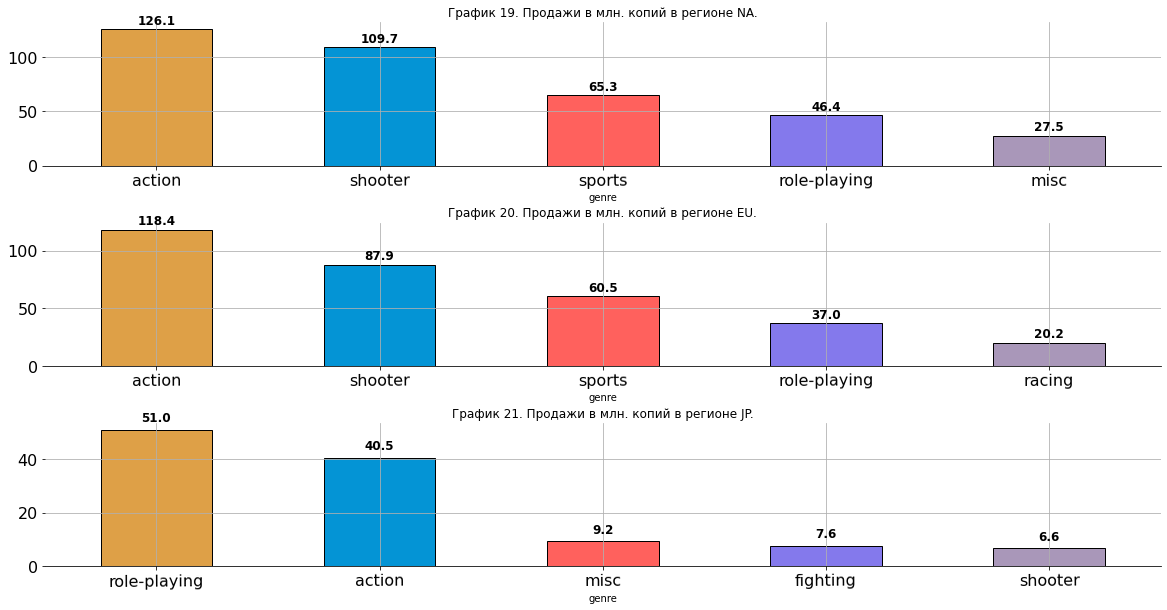

In [81]:
regions = ['na_sales', 'eu_sales', 'jp_sales'] # список колонок для группировки
titles = ['NA','EU','JP'] # список названий

plt.figure(figsize=(20, 10))
count = 0
for region in regions:
    ax = plt.subplot(3,1,count+1)
    ax =  (cleared_data.query('year_of_release >=2013')
           .groupby('genre')[regions[count]].sum().sort_values(ascending = False).head(5)
           .plot(
        kind = 'bar',
        ax = ax,
        grid = True,
        ec = 'black', 
        color = color_list ,rot = 0.45,
        title = f'График {count+19}. Продажи в млн. копий в регионе {titles[count]}.')
          )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both',labelsize=16)    
    
    #Надписи
    rects=ax.patches
    for rect in rects:    
        height = rect.get_height()    
        ax.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom", weight='bold',size='large')
    count +=1

plt.subplots_adjust(hspace=0.4, wspace=0.5)
    

Как видно из графиков на американском и европейском рынках жанры почти совпадают, только гонки более популярны в Европе.
Спортивные игры популярны, потому что очень развиты спортивные лиги (NFL, NHL, футбольные чемпионаты и тд.) и имеют массу поклонников. Игры жанра "role-playing" популярны в Японии, так как  имеют свою специфику и механики(которые, в свою очередь, не очень привлекают игроков с других рынков) и каждая уважающая себя японская игровая компания имеет линейку подобных игр. Также там популярны fighting - игры.

### Влияние рейтинга на продажи <a class="anchor" id="id_3n"></a>

---------------------------------------- NA ----------------------------------------


rating,ao,ec,e10+,m,t,e,rp
count,1.00,8.000,1395.000,1537.000,2908.000,3935.000,6677.000
mean,1.26,0.191,0.248,0.483,0.257,0.326,0.184
std,NaN,0.142,0.437,1.040,0.457,1.019,0.801
min,1.26,0.040,0.000,0.000,0.000,0.000,0.000
25%,1.26,0.080,0.050,0.050,0.040,0.050,0.000
50%,1.26,0.155,0.120,0.140,0.110,0.120,0.000
75%,1.26,0.290,0.270,0.440,0.270,0.310,0.120
max,1.26,0.420,5.950,9.700,6.620,41.360,29.080


---------------------------------------- EU ----------------------------------------


rating,ao,ec,e10+,m,t,e,rp
count,1.00,8.000,1395.000,1537.000,2908.000,3935.000,6677.000
mean,0.61,0.014,0.132,0.312,0.146,0.180,0.091
std,NaN,0.032,0.269,0.653,0.335,0.758,0.350
min,0.61,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.61,0.000,0.000,0.030,0.010,0.000,0.000
50%,0.61,0.000,0.030,0.090,0.040,0.030,0.000
75%,0.61,0.005,0.130,0.320,0.140,0.120,0.050
max,0.61,0.090,3.110,9.090,6.420,28.960,10.950


---------------------------------------- JP ----------------------------------------


rating,ao,ec,e10+,m,t,e,rp
count,1.0,8.0,1395.000,1537.000,2908.000,3935.000,6677.000
mean,0.0,0.0,0.029,0.041,0.052,0.051,0.125
std,NaN,0.0,0.167,0.127,0.222,0.306,0.385
min,0.0,0.0,0.000,0.000,0.000,0.000,0.000
25%,0.0,0.0,0.000,0.000,0.000,0.000,0.000
50%,0.0,0.0,0.000,0.000,0.000,0.000,0.020
75%,0.0,0.0,0.000,0.020,0.010,0.000,0.100
max,0.0,0.0,4.350,2.020,4.130,6.500,10.220


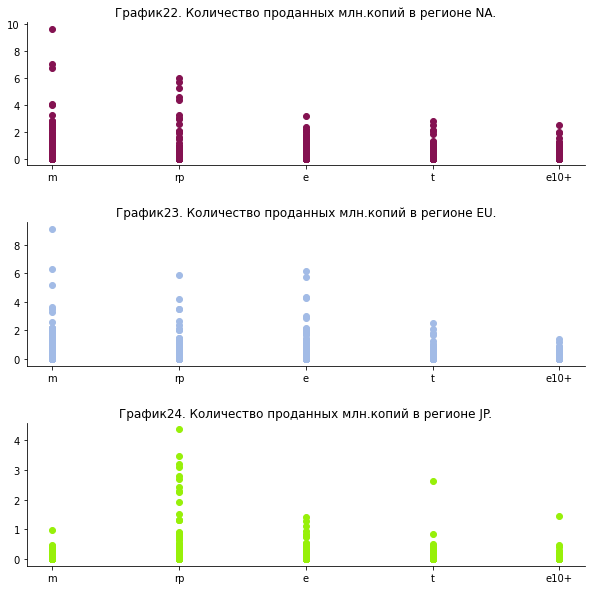

In [82]:
regions = ['na_sales', 'eu_sales', 'jp_sales'] # список колонок для группировки
titles = ['NA','EU','JP'] # список названий

plt.figure(figsize=(10, 10))
count = 0
for region in regions:
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
    ax = plt.subplot(3,1,count+1)
    ax.scatter(x=cleared_data.query('year_of_release >=2013')['rating'],
               y = cleared_data.query('year_of_release >=2013')[regions[count]],
               color = color) 
    
    ax.set_title(f'График{22+count}. Количество проданных млн.копий в регионе {titles[count]}.')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    print('-'*40,f'{titles[count]}','-'*40)
    display(cleared_data.groupby('rating')[regions[count]].describe().T.sort_values('count',axis = 1).round(3))
    count +=1    
plt.subplots_adjust(hspace=0.4, wspace=0.5)    
plt.show()

Наблюдая графики, видно, что игры с рейтингами "M" и "E" и "T" продаются  лучше(а в Японии игры категории "E" продаются еще лучше), потому что  эти категория включают в себя наибольшую долю целевой аудитории игр. Игры для взрослых имеют очень маленькие продажи. 

### Проверка гипотез <a class="anchor" id="id_3o"></a>

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <a class="anchor" id="id_3o1"></a>

*Нулевая гипотеза*: средние пользовательские рейтинги платформ Xbox One и PC равны.  
*Альтернативная гипотеза*: Средние пользовательские рейтинги платформ Xbox One и PC не равны.
Проверить эти гипотезы можно с помощью t-тестов, но при соблюдении следующих условий:  
 - Генеральные совокупности не должны зависеть друг от друга.
 - Выборочные средние должны быть нормально распределены.
   А если выборка всего одна, то её среднее должно иметь нормальное распределение для разных выборок этого размера из определённой генеральной совокупности.
 - Дисперсии рассматриваемых генеральных совокупностей должны быть равны.

1. Предположу, что оценки пользователей для компьютеров не зависят от оценок пользователей консоли xOne(то есть в таблице нет пользователей, которые владели бы обеими платформами, в таком случае их оценки были бы зависимы).

In [83]:
#Определение временного отрезка:
print(cleared_data.query('platform=="xone"')['year_of_release'].min(),
     cleared_data.query('platform=="xone"')['year_of_release'].max())

2013 2016


Так как компьютер присутствует на всем отрезке времени, то тогда времменной период будет 2013-2016 года.

In [84]:
#Выборка
sample = cleared_data.query('2013 <= year_of_release')
sample = sample.query('platform=="xone" | platform =="pc"').query('user_score !=(-1)')

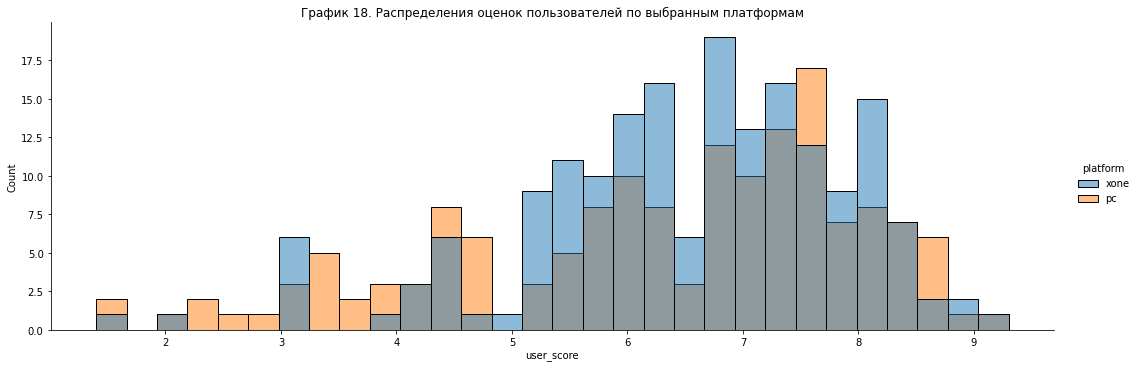

In [85]:
sns.displot(x = 'user_score', data= sample, kind = 'hist', hue = 'platform', bins = 30, aspect = 3).set(
title = "График 18. Распределения оценок пользователей по выбранным платформам")
plt.show()

Данные имеют негативную скошенность. Для проверки на нормальность распределения использую критерий Шапиро - Уилкса. В качестве критического уровня значимости возьму alpha = 0.05, как наиболее распространенный и не нужна излишняя точность.

In [86]:
#Для xOne
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(sample.query('platform=="xone"')['user_score'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение user_score для Xone не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение user_score для xOne нормально')
#Для PC    
results = st.shapiro(sample.query('platform=="pc"')['user_score'])
p_value = results[1]  
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение user_score для PC не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение user_score для PC нормально')    

p-значение:  1.5249203897838015e-05
Отвергаем нулевую гипотезу: распределение user_score для Xone не нормально
p-значение:  4.413724127516616e-06
Отвергаем нулевую гипотезу: распределение user_score для PC не нормально


2. Распределения не нормальны.

In [87]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample.query('platform=="xone"')['user_score'], sample.query('platform=="pc"')['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.16390354211387628
Не получилось отвергнуть нулевую гипотезу


Вычисление дисперсий, так как мы берем не всю генеральную совокупность, а выборку по годам, то использую параметр ddof = 1

In [88]:
variance_xone = np.var(sample.query('platform=="xone"')['user_score'], ddof=1)
variance_pc = np.var(sample.query('platform=="pc"')['user_score'], ddof=1)
print(variance_xone, variance_pc) 

1.9069968429360695 3.048193134822167


3. Дисперсии не равны. 

В таком случае использую непараметрический тест Уилкоксона-Манна-Уитни для определения результата:

In [89]:
#Определение достаточности размера выборок
print(sample.query('platform=="xone"').shape[0],sample.query('platform=="pc"').shape[0] )

182 156


In [90]:
results = st.mannwhitneyu(sample.query('platform=="xone"')['user_score'], sample.query('platform=="pc"')['user_score'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница между оценками игроков статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, статистической разницы между оценками игроков на двух платформах нет'
    )

p-значение:  0.5655160339922649
Не получилось отвергнуть нулевую гипотезу, статистической разницы между оценками игроков на двух платформах нет


**Вывод**: статистической разницы между оценками пользователей компьютеров и xOne за период 2013-2016гг нет.

#### Средние пользовательские рейтинги жанров Action и Sports за 2013-2016гг разные. <a class="anchor" id="id_3o2"></a>

*Нулевая гипотеза*: средние пользовательские рейтинги рейтинги жанров Action и Sports  равны.  
*Альтернативная гипотеза*: Средние пользовательские рейтинги рейтинги жанров Action и Sports не равны.  
Определение выборок:

In [91]:
sample_genres = (
    cleared_data.query('2013 <= year_of_release')
    .query('genre =="action" | genre =="sports"')
    .query('user_score !=(-1)')
                )

sample_action = sample_genres.query('genre == "action"')
sample_sports = sample_genres.query('genre == "sports"')

1. Предположу, что выборки оценок пользователей по жанрам независимы друг от друга.

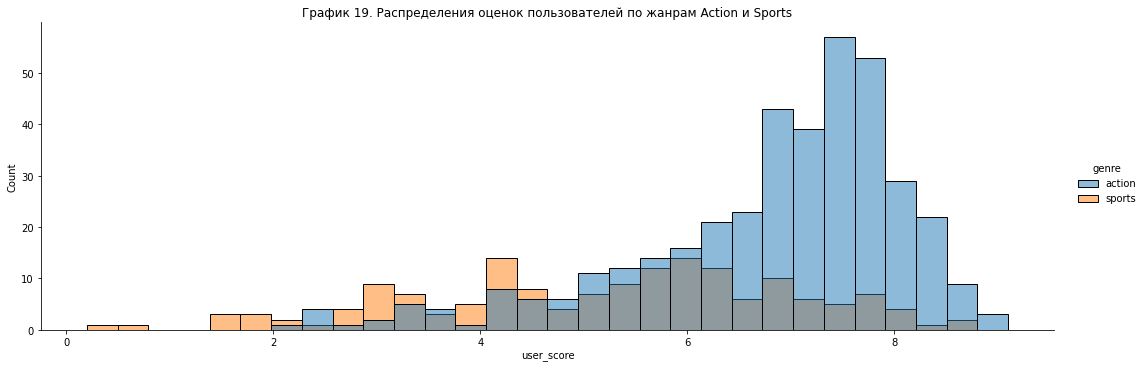

In [92]:
sns.displot(x = 'user_score', data= sample_genres, kind = 'hist', hue = 'genre', bins = 30, aspect = 3).set(
title = "График 19. Распределения оценок пользователей по жанрам Action и Sports")
plt.show()

Проверка на нормальность выборок:

In [93]:
#Для Action
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(sample_action['user_score'])
p_value = results[1]  
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение user_score для жанра Action не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение user_score для  жанра Actionнормально')

#Для Sports    
results = st.shapiro(sample_sports['user_score'])
p_value = results[1]  
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение user_score для  жанра Sports не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение user_score для  жанра Sports нормально')   

p-значение:  1.0693721502383867e-14
Отвергаем нулевую гипотезу: распределение user_score для жанра Action не нормально
p-значение:  0.03234051540493965
Отвергаем нулевую гипотезу: распределение user_score для  жанра Sports не нормально


2. Данные не распределены нормально

In [94]:
variance_action = np.var(sample_action['user_score'], ddof=1)
variance_sports = np.var(sample_sports['user_score'], ddof=1)
print(variance_action, variance_sports) 

1.7718990837782609 3.180612814465409


3. Дисперсии выборок отличаются. И в этом случае использую непараметрический тест Уилкоксона-Манна-Уитни для определения результата:

In [95]:
results = st.mannwhitneyu(sample_action['user_score'], sample_sports['user_score'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница между оценками игроков двух жанров статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, статистической разницы между оценками двух жанров  нет'
    )

p-значение:  1.1894191521874847e-23
Отвергаем нулевую гипотезу: разница между оценками игроков двух жанров статистически значима


**Вывод**: средние пользовательские рейтинги рейтинги жанров Action и Sports не равны.

## Выводы <a class="anchor" id="id_4"></a>

1. В таблице собраны данные по играм с 1980 по 2016 года.  
2. Максимальное количество игр было выпущено в 2008 году - 1441 игра.  
3. Больше всего игр(имеются в виду различных IP) было выпущено для Playstation 2(2134) и Nintendo DS(2122).
4. Больше всего продано копий игр для PS2 - 1247 млн, xbox 360 - 961 млн. и PS3 - 931 млн. 
5. Среднее время жизни платформы (компьютеры не считаются) - 9 лет.
6. Если рассматривать все платформы, то оценки критиков и пользователей имеют слабую положительную связь с глобальным продажами.
7. Игр жанра Action и Sports было продано больше всего (3308 и 2318). Если брать период 2013-2016 года, то action-игры также доминируют, также стали более популярны рпг-игры и приключения, спортивные игры тоже остались в топе.
8. В 2017 году будет продано примерно 63 млн. копий игр
9. В регионе Северной Америки лидером по продажам является платформы от Микрософт,XBox One и XBox 360, имеющие долю продаж почти 60% на родном рынке. Консоль Playstation 3 идет на третьем месте, 35% ее продаж приходится на этот рынок. Затем идут консоли нового поколения 3ds и Wii U. 
10. На европейском рынке по продажам лидирует Playstation 3, 37% ee продаж приходится на этот рынок. Также следует отметить популярность игр на компьютерах у европейцев, имеющих там 64% своих продаж.
11. На японском рынке доминируют консоли Нинтендо 3ds, а также другие японские платформы.
12. По жанрам в Америке и Европе доминируют Action и Sports игры, в Японии - японские рпг.
13. Рейтинг ESRB влияет на продажи игр в том плане, что игры для взрослых не имеют шансов на высокие продажи. Лучше всего продаются игры с рейтингами "E", "T", "M".
14. Cтатистической разницы между оценками пользователей компьютеров и xOne за период 2013-2016гг нет.
15. Cредние пользовательские рейтинги рейтинги жанров Action и Sports за период 2013-2016гг не равны.

In [96]:
print('Ошибок нет')

Ошибок нет
